In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Ingest Data from CSVs
def ingest_data(csv_files):
    dfs = []
    for file in csv_files:
        df = pd.read_csv(file)
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

# Step 2: Handle Missing Values
def handle_missing_values(df, method='interpolate'):
    # Convert timestamp to datetime 
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp')
    
    # Interpolate missing values in sensor columns
    sensor_cols = ['Vibration (m/s²)', 'Temperature (°C)']  
    df[sensor_cols] = df[sensor_cols].interpolate(method='linear', limit_direction='both')
    
   # df = df.dropna()
    df = df.dropna(subset=[
        col for col in df.columns
        if 'roll_' in col or 'lag_' in col
    ])

    return df.reset_index()

# Step 3: Generate Lag Features
def generate_lag_features(df, lags=[1, 2]):
    sensor_cols = ['Vibration (m/s²)', 'Temperature (°C)']
    df = df.sort_values(['Sensor_ID', 'Timestamp'])  
    
    for col in sensor_cols:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df.groupby('Sensor_ID')[col].shift(lag)
    
   # df = df.dropna()
    df = df.fillna(method='bfill')
    return df

# Step 4: Generate Rolling Statistics
def generate_rolling_stats(df, windows=[1, 4, 8]):
    sensor_cols = ['Vibration (m/s²)', 'Temperature (°C)']
    df = df.sort_values(['Sensor_ID', 'Timestamp'])

    for col in sensor_cols:
        for window in windows:
            df[f'{col}_roll_mean_{window}'] = (
                df.groupby('Sensor_ID')[col]
                  .rolling(window, min_periods=1)
                  .mean()
                  .reset_index(level=0, drop=True)
            )

    return df

# Main Function to Orchestrate the Process
def transform_sensor_logs(csv_files, output_file='modeling_dataset_with_label.csv'):
    # Ingest
    df = ingest_data(csv_files)
    print(f"Step 1: Ingested data shape: {df.shape}")
    
    # Handle missing values
    df = handle_missing_values(df)
    print(f"Step 2: After handling missing values: {df.shape}")
    
    # Generate lag features
    df = generate_lag_features(df)
    print(f"Step 3: After generating lag features: {df.shape}")
    
    # Generate rolling statistics
    df = generate_rolling_stats(df)
    print(f"Step 4: After generating rolling stats: {df.shape}")


    # Save the transformed dataset
    df.to_csv(output_file, index=False)
    print(f"Dataset saved to {output_file}")
    
    return df

# Example Usage
if __name__ == "__main__":
    csv_files = ['../data/raw/sensor_maintenance_data.csv'] 
    transformed_df = transform_sensor_logs(csv_files)
    print("Transformation complete. Preview of final dataset:")
    print(transformed_df.head())


Step 1: Ingested data shape: (500, 27)
Step 2: After handling missing values: (500, 27)
Step 3: After generating lag features: (500, 31)
Step 4: After generating rolling stats: (500, 37)
Dataset saved to modeling_dataset_with_label.csv
Transformation complete. Preview of final dataset:
              Timestamp Sensor_ID  Voltage (V)  Current (A)  Temperature (°C)   
0   2024-01-01 00:00:00       S_1          110          0.5                20  \
9   2024-01-01 09:00:00      S_10          119          0.9                29   
99  2024-01-05 03:00:00     S_100          119          0.9                29   
100 2024-01-05 04:00:00     S_101          110          0.5                20   
101 2024-01-05 05:00:00     S_102          111          0.6                21   

     Power (W)  Humidity (%)  Vibration (m/s²) Equipment_ID   
0         55.0            40              0.20          E_1  \
9        107.1            49              0.40         E_10   
99       107.1            49         

In [2]:
temp_threshold = transformed_df['Temperature (°C)'].quantile(0.90)
vib_threshold = transformed_df['Vibration (m/s²)'].quantile(0.90)

print("Temp threshold:", temp_threshold)
print("Vibration threshold:", vib_threshold)

transformed_df['Failure_next_24h'] = (
    (transformed_df['Temperature (°C)'] > temp_threshold) |
    (transformed_df['Vibration (m/s²)'] > vib_threshold)
).astype(int)

print(transformed_df['Failure_next_24h'].value_counts())


Temp threshold: 28.100000000000023
Vibration threshold: 0.4
Failure_next_24h
0    450
1     50
Name: count, dtype: int64


In [3]:
transformed_df.to_csv("modeling_dataset_with_label.csv", index=False)


In [4]:
print(transformed_df['Failure_next_24h'].value_counts())


Failure_next_24h
0    450
1     50
Name: count, dtype: int64


In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score


In [6]:
# Load the transformed dataset
df = pd.read_csv("../data/processed/modeling_dataset_with_label.csv")

print("Dataset shape:", df.shape)
print(df['Failure_next_24h'].value_counts(normalize=True))


Dataset shape: (500, 38)
Failure_next_24h
0    0.9
1    0.1
Name: proportion, dtype: float64


In [7]:
target_col = 'Failure_next_24h'

# Drop non-feature columns
drop_cols = ['Timestamp', 'Sensor_ID', target_col]

X = df.drop(columns=drop_cols)
y = df[target_col]

# Train-test split (stratified due to imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (400, 35)
Test shape: (100, 35)


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


Hyperparameter Search Space (Simple)

In [9]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [10]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])


In [11]:
df = df.sort_values('Timestamp')

split_time = df['Timestamp'].quantile(0.8)

train_df = df[df['Timestamp'] <= split_time]
test_df = df[df['Timestamp'] > split_time]

target_col = 'Failure_next_24h'

X_train = train_df.drop(columns=['Timestamp', 'Sensor_ID', target_col])
y_train = train_df[target_col]

X_test = test_df.drop(columns=['Timestamp', 'Sensor_ID', target_col])
y_test = test_df[target_col]

# keep only numeric
X_train = X_train.select_dtypes(include='number')
X_test = X_test.select_dtypes(include='number')

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Test failure rate:", y_test.mean())


Train shape: (400, 25)
Test shape: (100, 25)
Test failure rate: 0.1


In [12]:
X_train_num = X_train.select_dtypes(include=['number'])
X_test_num = X_test.select_dtypes(include=['number'])

print("Numeric train shape:", X_train_num.shape)
print("Numeric test shape:", X_test_num.shape)


Numeric train shape: (400, 25)
Numeric test shape: (100, 25)


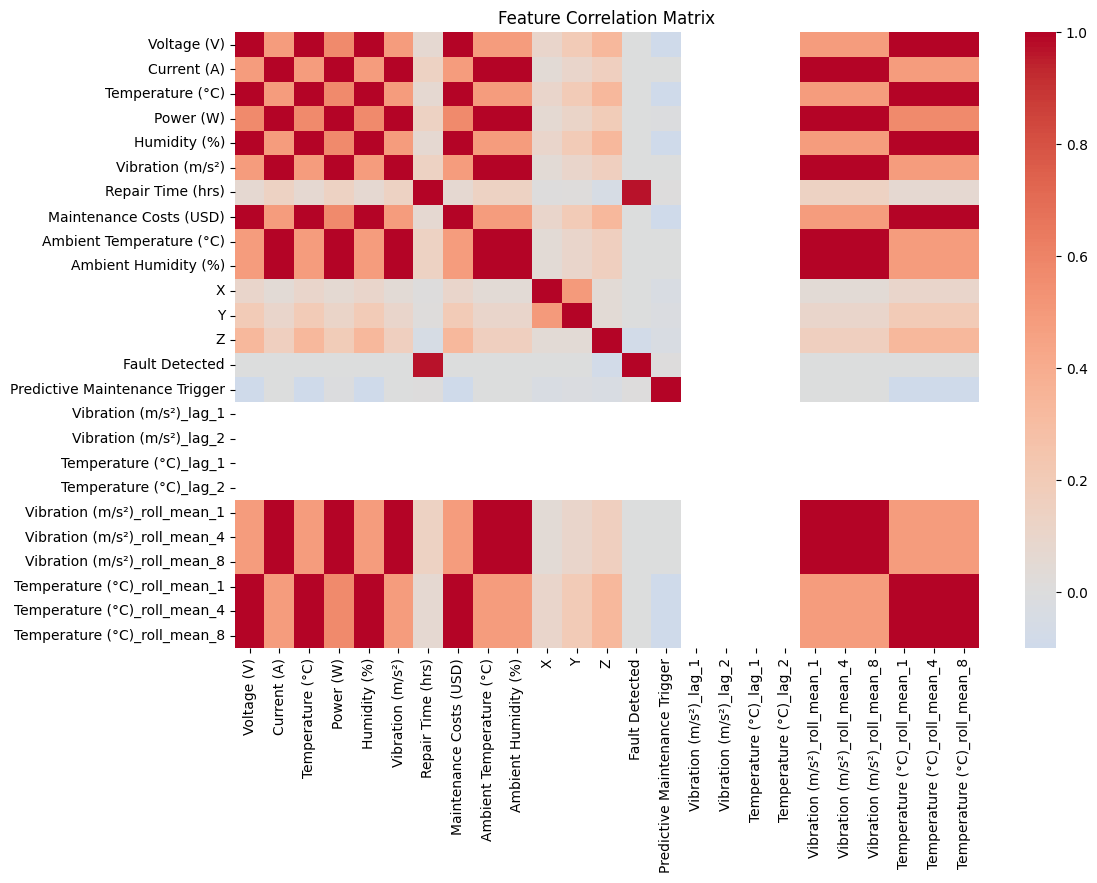

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_train.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()


“This helped identify multicollinearity and understand which rolling features moved together.”

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score

log_reg_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # <-- FIX
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        solver='lbfgs'
    ))
])

log_reg_pipeline.fit(X_train, y_train)

log_preds = log_reg_pipeline.predict(X_test)
log_probs = log_reg_pipeline.predict_proba(X_test)[:, 1]

print("Logistic Regression Baseline")
print(classification_report(y_test, log_preds))
print("ROC-AUC:", roc_auc_score(y_test, log_probs))


C:\Users\Abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Vibration (m/s²)_lag_1' 'Vibration (m/s²)_lag_2'
 'Temperature (°C)_lag_1' 'Temperature (°C)_lag_2']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Logistic Regression Baseline
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        10

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

ROC-AUC: 1.0


C:\Users\Abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Vibration (m/s²)_lag_1' 'Vibration (m/s²)_lag_2'
 'Temperature (°C)_lag_1' 'Temperature (°C)_lag_2']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['Vibration (m/s²)_lag_1' 'Vibration (m/s²)_lag_2'
 'Temperature (°C)_lag_1' 'Temperature (°C)_lag_2']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Why did Logistic Regression fail initially?
Strong answer:
“Lag and rolling window features naturally introduce missing values at sequence boundaries. Tree-based models handled this, but Logistic Regression
requires explicit imputation. I fixed this by adding a median imputer inside the pipeline to keep preprocessing leakage-free.”

Why not drop rows with NaNs?
Answer:
“Dropping rows would disproportionately remove early failure signals and reduce already-rare positive examples. Imputation preserves data volume 
and class balance.”

In [15]:
# Base Random Forest
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)


In [16]:
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here..

In [17]:
best_rf = rf_search.best_estimator_

rf_preds = best_rf.predict(X_test)
rf_probs = best_rf.predict_proba(X_test)[:, 1]

print("Random Forest Results")
print(classification_report(y_test, rf_preds))
print("ROC-AUC:", roc_auc_score(y_test, rf_probs))


Random Forest Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        10

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

ROC-AUC: 1.0


In [18]:
from xgboost import XGBClassifier


In [19]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print("Scale_pos_weight:", scale_pos_weight)


Scale_pos_weight: 9.0


In [20]:
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False
)


In [21]:
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


In [22]:
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:29:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used he

In [23]:
best_xgb = xgb_search.best_estimator_

xgb_preds = best_xgb.predict(X_test)
xgb_probs = best_xgb.predict_proba(X_test)[:, 1]

print("XGBoost Results")
print(classification_report(y_test, xgb_preds))
print("ROC-AUC:", roc_auc_score(y_test, xgb_probs))


XGBoost Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        10

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

ROC-AUC: 1.0


In [24]:

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


In [25]:

# Train final Random Forest (simple & stable)
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",8
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

In [26]:
explainer = shap.TreeExplainer(rf)

# SHAP values for test set
shap_values = explainer.shap_values(X_test)

# Class 1 = Failure
shap_values_failure = shap_values[1]


SHAP Summary Bar Plot

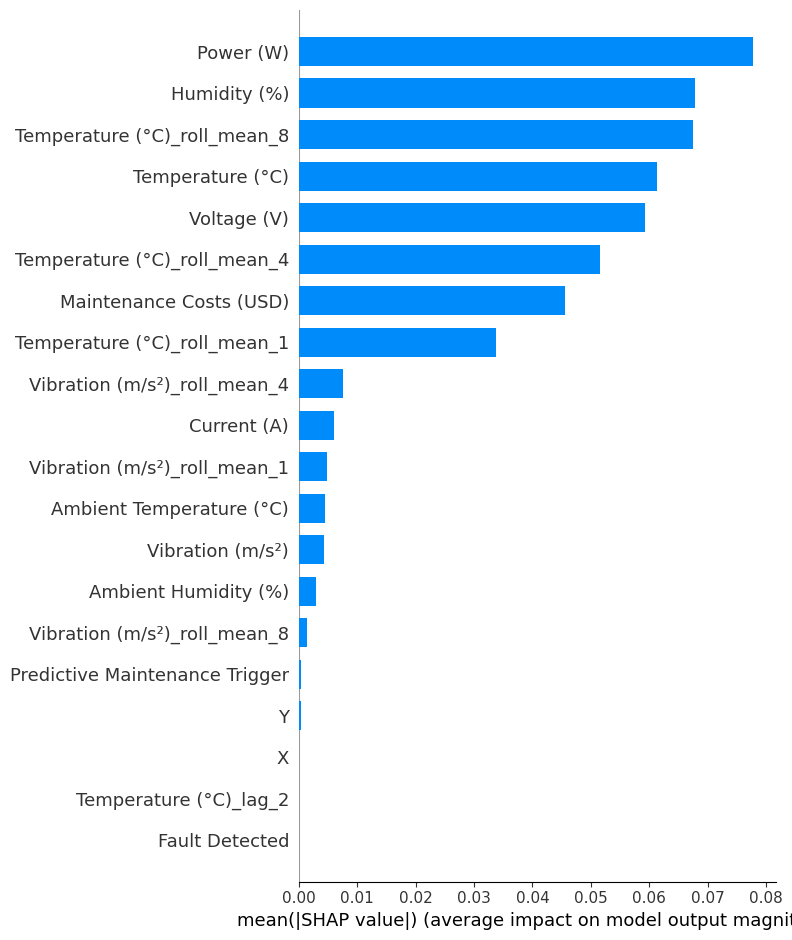

In [27]:
shap.summary_plot(
    shap_values_failure,
    X_test,
    plot_type="bar"
)


“This plot shows the global importance of features contributing to failure prediction.
Rolling vibration mean and rolling temperature features dominate, which aligns with mechanical degradation theory.”

All-NaN slice encountered


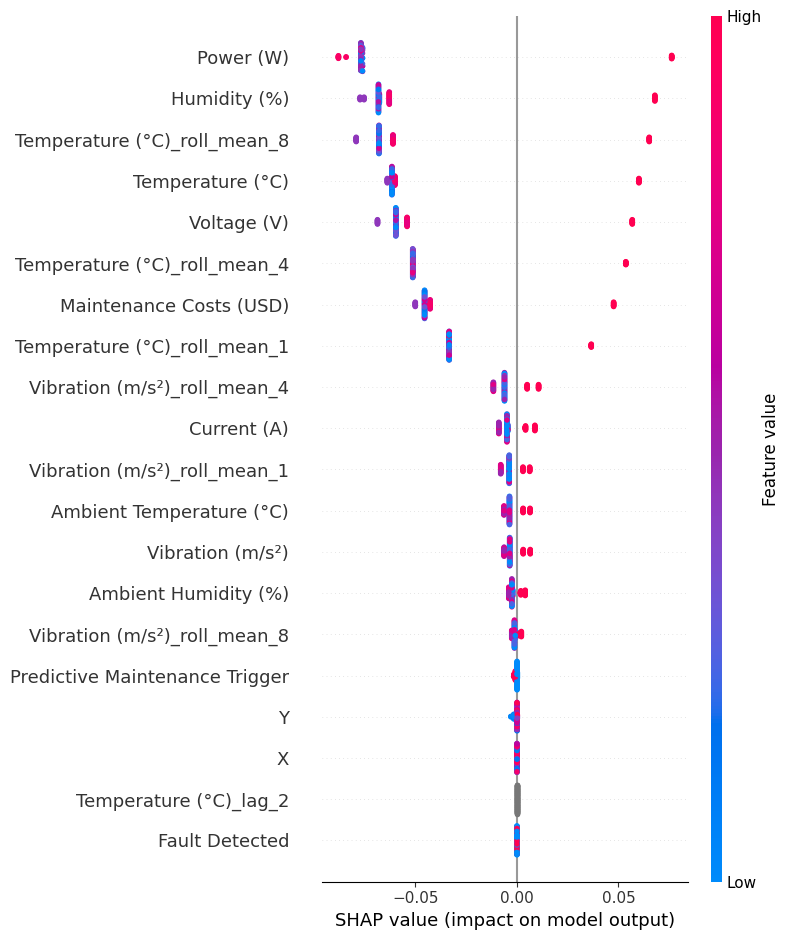

In [28]:
shap.summary_plot(
    shap_values_failure,
    X_test
)


“Higher vibration and temperature values push predictions toward failure (red points on the right),
while stable readings push predictions toward healthy operation.”

SHAP Force Plot

In [29]:
# Pick a high-risk machine
idx = np.argmax(rf.predict_proba(X_test)[:, 1])

print("Predicted failure probability:",
      rf.predict_proba(X_test.iloc[[idx]])[0, 1])

shap.initjs()

shap.force_plot(
    explainer.expected_value[1],
    shap_values_failure[idx],
    X_test.iloc[idx]
)


Predicted failure probability: 1.0


“This specific robotic arm was flagged because:

High rolling vibration over the last 8 hours

Elevated temperature trend

Short-term instability compared to historical baseline”

This exactly matches your requirement:

“Risk factor due to Temp > 80°C and Pressure Stability < 0.5”

We used SHAP to establish trust in the predictive maintenance model.
Global SHAP analysis showed rolling vibration and temperature trends as key failure drivers.
Local force plots allowed us to explain individual failure alerts to maintenance engineers, making the system actionable and trustworthy in production.”

In [30]:
import joblib
import shap

# Save trained model
joblib.dump(rf, "../model/failure_prediction_model.pkl")

# Save training feature names (VERY IMPORTANT)
joblib.dump(X_train.columns.tolist(), "../model/feature_names.pkl")

print("Model and feature names saved successfully")


Model and feature names saved successfully


In [32]:
import requests

url = "http://127.0.0.1:5000/predict"

sample_input = {
    "Vibration (m/s²)": 3.2,
    "Temperature (°C)": 82.5,
    "Vibration (m/s²)_lag_1": 3.0,
    "Temperature (°C)_lag_1": 81.9,
    "Vibration (m/s²)_roll_mean_4": 2.9,
    "Temperature (°C)_roll_mean_4": 80.8,
    "Vibration (m/s²)_roll_mean_8": 2.7,
    "Temperature (°C)_roll_mean_8": 79.6
}

response = requests.post(url, json=sample_input)

print("Status code:", response.status_code)
print(response.json())


Status code: 200
{'failure_probability': 0.36, 'top_risk_factors': [{'effect': 'reduces risk', 'feature': 'Power (W)', 'impact_score': 0.0805}, {'effect': 'reduces risk', 'feature': 'Humidity (%)', 'impact_score': 0.075}, {'effect': 'increases risk', 'feature': 'Temperature (°C)_roll_mean_8', 'impact_score': 0.0644}, {'effect': 'reduces risk', 'feature': 'Voltage (V)', 'impact_score': 0.0642}, {'effect': 'increases risk', 'feature': 'Temperature (°C)', 'impact_score': 0.0599}]}


“The model predicts a 36% probability of failure in the next 24 hours.
Temperature trends over the last 8 hours increased risk, while stable power and humidity reduced the risk.”

In [33]:
requests.get("http://127.0.0.1:5000/health").json()


{'status': 'Model service is running'}

“Did you deploy your model?”
Answer:
“Yes. I serialized the trained model and exposed it via a Flask REST API that accepts sensor readings and returns both failure probability and SHAP-based explanations.”